In [11]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custoam.css", "r").read()
    return HTML(styles)

css_styling()

FileNotFoundError: [Errno 2] No such file or directory: './styles/custoam.css'

In [1]:
import glob
import os
datapath = os.environ.get("DATASETS")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from pytorch_lightning import LightningModule, Trainer

In [4]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filelist[index])
        img = Image.open(imgpath)

        label = 1 if "dog" in imgpath else 0
        img = self.transform(img)

        return (img, label)


train_dir = f"../Datasets/dogs-vs-cats/dogs-vs-cats/train"
test_dir = f"{datapath}/dogs-vs-cats/dogs-vs-cats/test1"

train_files = [f for f in glob.glob('../Datasets/dogs-vs-cats/dogs-vs-cats/train/*/*.jpg')]
test_files = [f for f in glob.glob('../Datasets/dogs-vs-cats/dogs-vs-cats/test1/*.jpg')]

transformations = Compose([
    Resize((60, 60)),
    ToTensor(),
])

train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

train, val = random_split(train, [0.8, 0.2])

In [5]:
train.dataset.filelist.__len__()

25000

In [6]:
train.dataset.filepath

'../Datasets/dogs-vs-cats/dogs-vs-cats/train'

In [7]:
train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size= 2, shuffle=False)

In [98]:
a = iter(train_loader)

In [ ]:
next(a)

### Lightening model

In [7]:
from torch.nn import Conv2d, Flatten, Linear, MaxPool2d, ReLU, Sequential, CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from pytorch_lightning.tuner import Tuner
from torchmetrics import Accuracy

In [8]:
class LitModel(LightningModule):
    def __init__(self, batch_size, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.accuracy = Accuracy(task="binary")
        self.train_acc = Accuracy(task="binary")
        self.valid_acc = Accuracy(task="binary")

        self.conv1 = Sequential(Conv2d(in_channels=3, out_channels=16, kernel_size=3), ReLU(), MaxPool2d(2, 2))
        self.conv2 = Sequential(Conv2d(16, 32, 3), ReLU(), MaxPool2d(2, 2))
        self.conv3 = Sequential(Conv2d(32, 64, 3), ReLU(), MaxPool2d(2, 2))
        
        self.fc1 = Sequential(Flatten(), Linear(64*5*5, 256), ReLU(), Linear(256, 128), ReLU())
        self.fc2 = Sequential(Linear(128, 2))
        
    def train_dataloader(self):
        return DataLoader(dataset=train, batch_size=32, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(dataset=val, batch_size=32, shuffle=False)
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)
    
    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = CrossEntropyLoss()(output, label)
        self.log("train loss: ", loss)
        
        return {"loss": loss, "log": self.log}
    
    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = CrossEntropyLoss()(val_output, val_label)
        self.log("val_loss", val_loss)
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)

In [9]:
model = LitModel(batch_size=32, learning_rate=0.001)

In [10]:
trainer = Trainer(max_epochs=10)
tuner = Tuner(trainer=trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
%%time
lr = tuner.lr_find(model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.000630957344480193
Restoring states from the checkpoint path at C:\Users\Harry\Documents\DS\Modern-CV-Rejeev-D-Ratan-Udemy\.lr_find_3f1586fb-3cfe-4b50-8a21-7cde9bab7d96.ckpt
Restored all states from the checkpoint at C:\Users\Harry\Documents\DS\Modern-CV-Rejeev-D-Ratan-Udemy\.lr_find_3f1586fb-3cfe-4b50-8a21-7cde9bab7d96.ckpt


Wall time: 18min 15s


<ipython-input-12-e6b47cacf01b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


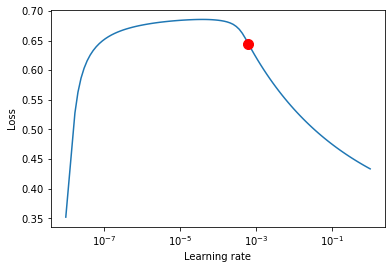

In [12]:
fig = lr.plot(suggest=True)
fig.show()

In [13]:
lr.suggestion()

0.000630957344480193

In [ ]:
%%time
tuner.scale_batch_size(model=model)

In [14]:
%%time
history = trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | train_acc | BinaryAccuracy | 0     
2 | valid_acc | BinaryAccuracy | 0     
3 | conv1     | Sequential     | 448   
4 | conv2     | Sequential     | 4.6 K 
5 | conv3     | Sequential     | 18.5 K
6 | fc1       | Sequential     | 442 K 
7 | fc2       | Sequential     | 258   
---------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Wall time: 35min 40s


In [20]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     validation loss:      │    0.3132619857788086     │
└───────────────────────────┴───────────────────────────┘

[{'validation loss: ': 0.3132619857788086}]

### Using callbacks

In [11]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,  # epochs to wait
    strict=False,
    mode="min",
    verbose=False,
)
checkpoint_callback = ModelCheckpoint(
    dirpath="models/",
    filename="sample-catsvsdogs-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    save_top_k=2,
    mode="min",
)

In [13]:
trainer = Trainer(
    max_epochs=10,
    callbacks=[early_stop, checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | train_acc | BinaryAccuracy | 0     
2 | valid_acc | BinaryAccuracy | 0     
3 | conv1     | Sequential     | 448   
4 | conv2     | Sequential     | 4.6 K 
5 | conv3     | Sequential     | 18.5 K
6 | fc1       | Sequential     | 442 K 
7 | fc2       | Sequential     | 258   
---------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Profiler

In [15]:
trainer = Trainer(
    max_epochs=1,
    profiler="simple"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | accuracy  | BinaryAccuracy | 0     
1 | train_acc | BinaryAccuracy | 0     
2 | valid_acc | BinaryAccuracy | 0     
3 | conv1     | Sequential     | 448   
4 | conv2     | Sequential     | 4.6 K 
5 | conv3     | Sequential     | 18.5 K
6 | fc1       | Sequential     | 442 K 
7 | fc2       | Sequential     | 258   
---------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Harry\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                 

In [31]:
%load_ext tensorboard

In [32]:
%tensorboard --logdir lightning_logs/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 11608.